In [14]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from os.path import join
import csv
from tqdm.auto import tqdm
import re
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler , PolynomialFeatures
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor , GradientBoostingRegressor 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error , r2_score
from xgboost import XGBRegressor
from Feature_engineering.FE import *
from Feature_engineering.utils import *
from Feature_engineering.ProjectPaths import *

# Data For Validating Models

In [16]:
os.makedirs(output_folder_paths,exist_ok=True)
os.makedirs(golden_iv_paths,exist_ok=True)
os.makedirs(eugene_iv_paths,exist_ok=True)
os.makedirs(cocoa_iv_paths,exist_ok=True)

In [17]:
cocoa_datasets=[join(folder_path,"Cocoa",paths) for paths in os.listdir(join(folder_path,"Cocoa")) if paths.split(".")[-1]=="csv"]
eugene_datasets=[join(folder_path,"Eugene",paths) for paths in os.listdir(join(folder_path,"Eugene")) if paths.split(".")[-1]=="csv"]
golden_datasets=[join(folder_path,"Golden",paths) for paths in os.listdir(join(folder_path,"Golden")) if paths.split(".")[-1]=="csv"]

In [18]:
golden_df=pretty_csv(golden_datasets,golden_iv_paths)
eugene_df=pretty_csv(eugene_datasets,eugene_iv_paths)
cocoa_df=pretty_csv(cocoa_datasets,cocoa_iv_paths)


golden_df.rename(columns=rename_dict,inplace=True)
eugene_df.rename(columns=rename_dict,inplace=True)
cocoa_df.rename(columns=rename_dict,inplace=True)

golden_df.to_csv(join(output_folder_paths,"golden.csv"),index=False)
eugene_df.to_csv(join(output_folder_paths,"eugene.csv"),index=False)
cocoa_df.to_csv(join(output_folder_paths,"cocoa.csv"),index=False)

In [19]:
golden_df=pd.read_csv(join(output_folder_paths,"golden.csv"))
eugene_df=pd.read_csv(join(output_folder_paths,"eugene.csv"))
cocoa_df=pd.read_csv(join(output_folder_paths,"cocoa.csv"))

In [20]:
main_df=pd.concat([golden_df,eugene_df,cocoa_df],axis=0)
# main_df=golden_df

In [21]:
main_df.columns

Index(['TimeStamp', 'POA_CMP22', 'POA_unc', 'Mod_Temp', 'Mod_Temp_unc',
       'Isc (A)', 'Isc_unc', 'Pmp (W)', 'Pmp_unc', 'Imp (A)', 'Imp_unc',
       'Vmp (V)', 'Vmp_unc', 'Voc (V)', 'Voc_unc', 'FF (%FF)', 'FF_unc',
       'CMP22_delta', 'LICOR_delta', 'Cab_Temp', 'Dry_Temp', 'Dry_Temp_unc',
       'RH', 'RH_unc', 'Pressure', 'Pressure_unc', 'Precip', 'DNI', 'DNI_unc',
       'DNI_std', 'GHI', 'GHI_unc', 'GHI_std', 'DHI', 'DHI_unc', 'DHI_std',
       'QA_residual', 'Soiling', 'Precip_pre_maint', 'Num_IV_pairs',
       'I-V paths', 'filename'],
      dtype='object')

In [22]:
main_df["filename"]=main_df["filename"].apply(lambda x : x.split("_")[-1])

In [23]:
main_df.groupby("filename")["filename"].value_counts()

filename
CIGS1-001         12011
CIGS39013         11437
CIGS39017         77449
CIGS8-001         82085
CdTe75638         81328
CdTe75669         11953
HIT05662          11876
HIT05667          81648
aSiMicro03036     82380
aSiMicro03038     12148
aSiTandem72-46    82452
aSiTandem90-31    12070
aSiTriple28324    81190
aSiTriple28325    11445
mSi0166           80033
mSi0188           82229
mSi0247           11912
mSi0251           11887
mSi460A8          82044
mSi460BB          11919
xSi11246          11929
xSi12922          82174
Name: count, dtype: int64

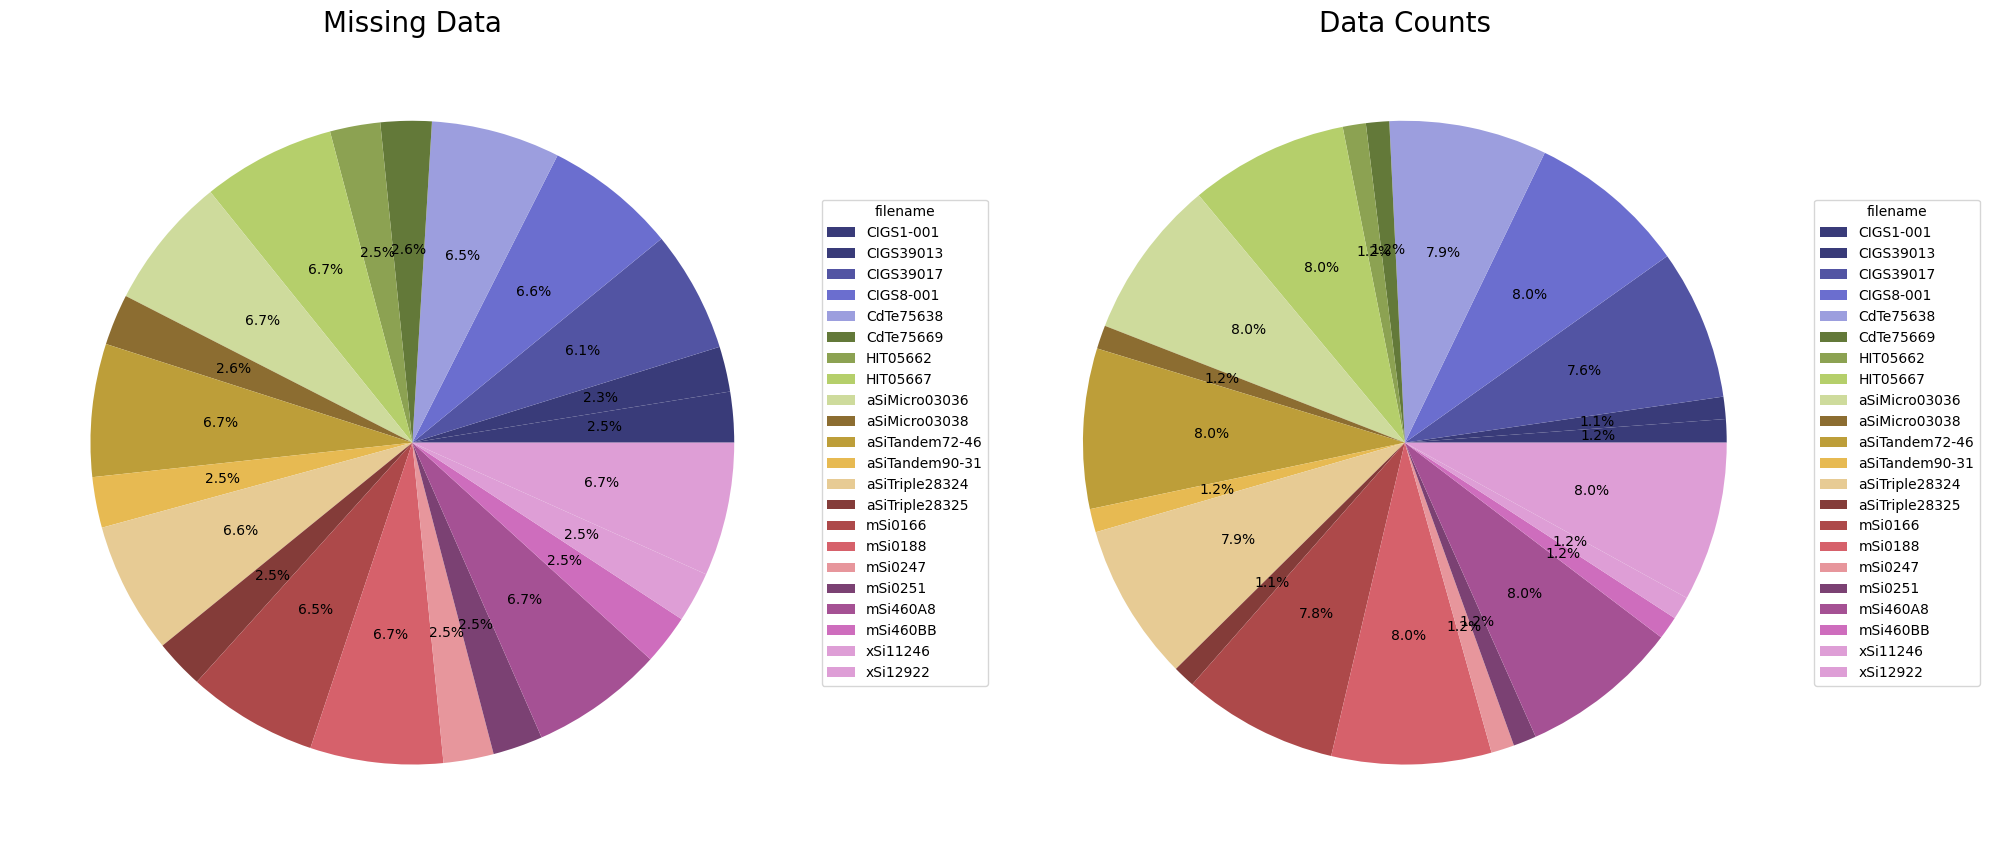

In [24]:
fig,ax=plt.subplots(1,2,figsize=(20,10))

missing_data=main_df[(main_df["DNI_unc"]<0) | (main_df["GHI_unc"]<0)]["filename"].value_counts()
missing_data=missing_data.sort_index()

cmap   = plt.get_cmap("tab20b")  
colors = cmap(np.linspace(0, 1, len(missing_data)))

wedges,_,_=ax[0].pie(missing_data,autopct="%1.1f%%",colors=colors)
ax[0].legend(
    wedges,
    missing_data.index,
    title="filename",
    loc="center left",
    bbox_to_anchor=(1, 0.5),
)

data_counts=main_df.groupby("filename")["filename"].value_counts()
data_counts=data_counts.sort_index()
wedges,_,_=ax[1].pie(data_counts,autopct="%1.1f%%",colors=colors)
ax[1].legend(
    wedges,
    missing_data.index,
    title="filename",
    loc="center left",
    bbox_to_anchor=(1, 0.5)
)


ax[0].set_title("Missing Data", fontsize=20)
ax[1].set_title("Data Counts", fontsize=20)
plt.tight_layout()

In [25]:
print(len(main_df))
main_df=remove_invalid_rows(main_df)
print(len(main_df))

1025599
769595


In [26]:
main_df.describe().min()

POA_CMP22           2.000000e+01
POA_unc            -9.999000e+03
Mod_Temp           -1.890000e+01
Mod_Temp_unc        3.330671e-15
Isc (A)             7.300000e-03
Isc_unc             2.000000e-01
Pmp (W)             1.395000e-01
Pmp_unc             3.000000e-01
Imp (A)             5.200000e-03
Imp_unc             2.000000e-01
Vmp (V)             3.785800e+00
Vmp_unc             2.000000e-01
Voc (V)             7.465300e+00
Voc_unc             1.346477e-01
FF (%FF)            9.321389e+00
FF_unc              4.000000e-01
CMP22_delta         0.000000e+00
LICOR_delta         0.000000e+00
Cab_Temp            2.806727e+00
Dry_Temp           -1.610000e+01
Dry_Temp_unc       -9.999000e+03
RH                  4.600000e+00
RH_unc             -9.999000e+03
Pressure            5.677143e+01
Pressure_unc       -9.999000e+03
Precip             -9.999000e+03
DNI                 6.000000e-01
DNI_unc             1.000000e+00
DNI_std            -9.999000e+03
GHI                 1.030000e+01
GHI_unc   

In [27]:
main_df.dtypes

TimeStamp            object
POA_CMP22           float64
POA_unc             float64
Mod_Temp            float64
Mod_Temp_unc        float64
Isc (A)             float64
Isc_unc             float64
Pmp (W)             float64
Pmp_unc             float64
Imp (A)             float64
Imp_unc             float64
Vmp (V)             float64
Vmp_unc             float64
Voc (V)             float64
Voc_unc             float64
FF (%FF)            float64
FF_unc              float64
CMP22_delta         float64
LICOR_delta         float64
Cab_Temp            float64
Dry_Temp            float64
Dry_Temp_unc        float64
RH                  float64
RH_unc              float64
Pressure            float64
Pressure_unc        float64
Precip              float64
DNI                 float64
DNI_unc             float64
DNI_std             float64
GHI                 float64
GHI_unc             float64
GHI_std             float64
DHI                 float64
DHI_unc             float64
DHI_std             

In [28]:
columns=main_df.columns
unc_cols = [col for col in main_df.columns if (col.endswith('_unc') or col.endswith("_std"))]
lickage_features=["Isc (A)","TimeStamp","FF (%FF)","Voc (V)"]+unc_cols

In [29]:
to_drop=lickage_features+["filename","I-V paths"]

In [30]:
corr=(main_df.drop(columns=to_drop)).corr()
uncorrlated_cols=[]
for col in corr.columns : 
    if(corr[col].sum()==0):
        uncorrlated_cols.append(col)
print("removing these columns : ",uncorrlated_cols)
main_df.drop(columns=uncorrlated_cols,inplace=True)
columns=main_df.columns

removing these columns :  []


<Axes: >

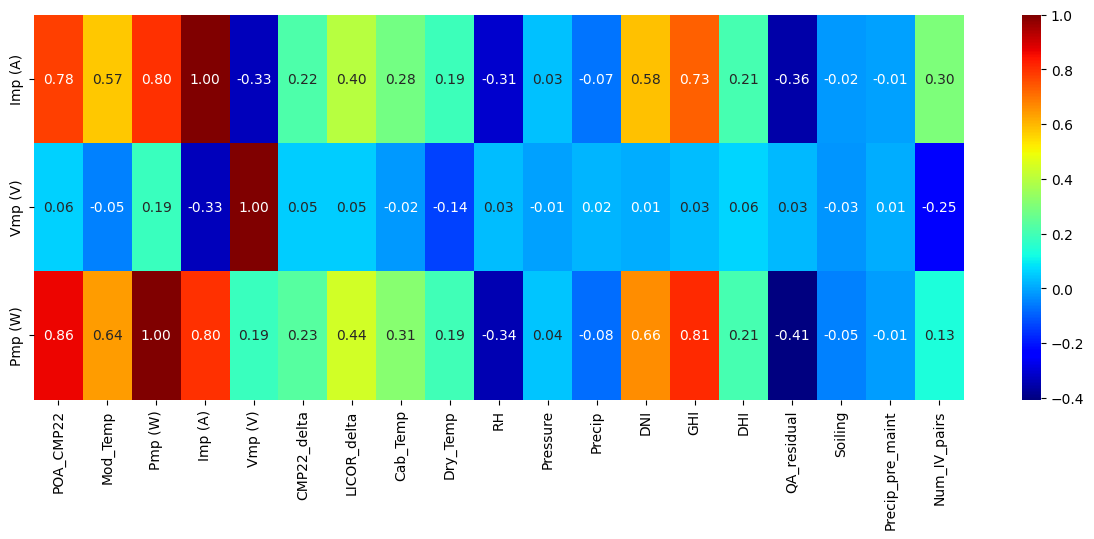

In [31]:
corr=(main_df.drop(columns=to_drop)).corr(method="spearman")
fig,ax=plt.subplots(1,1,figsize=(15,5))
sns.heatmap(corr[["Imp (A)","Vmp (V)","Pmp (W)"]].T,ax=ax,cmap="jet",annot=True,fmt=".2f")#mask=np.tri(corr.shape[0]).T
# corr["Imp (A)"].sort_values()

Text(0.5, 1.0, 'Correlations For Vmp (V) spearman')

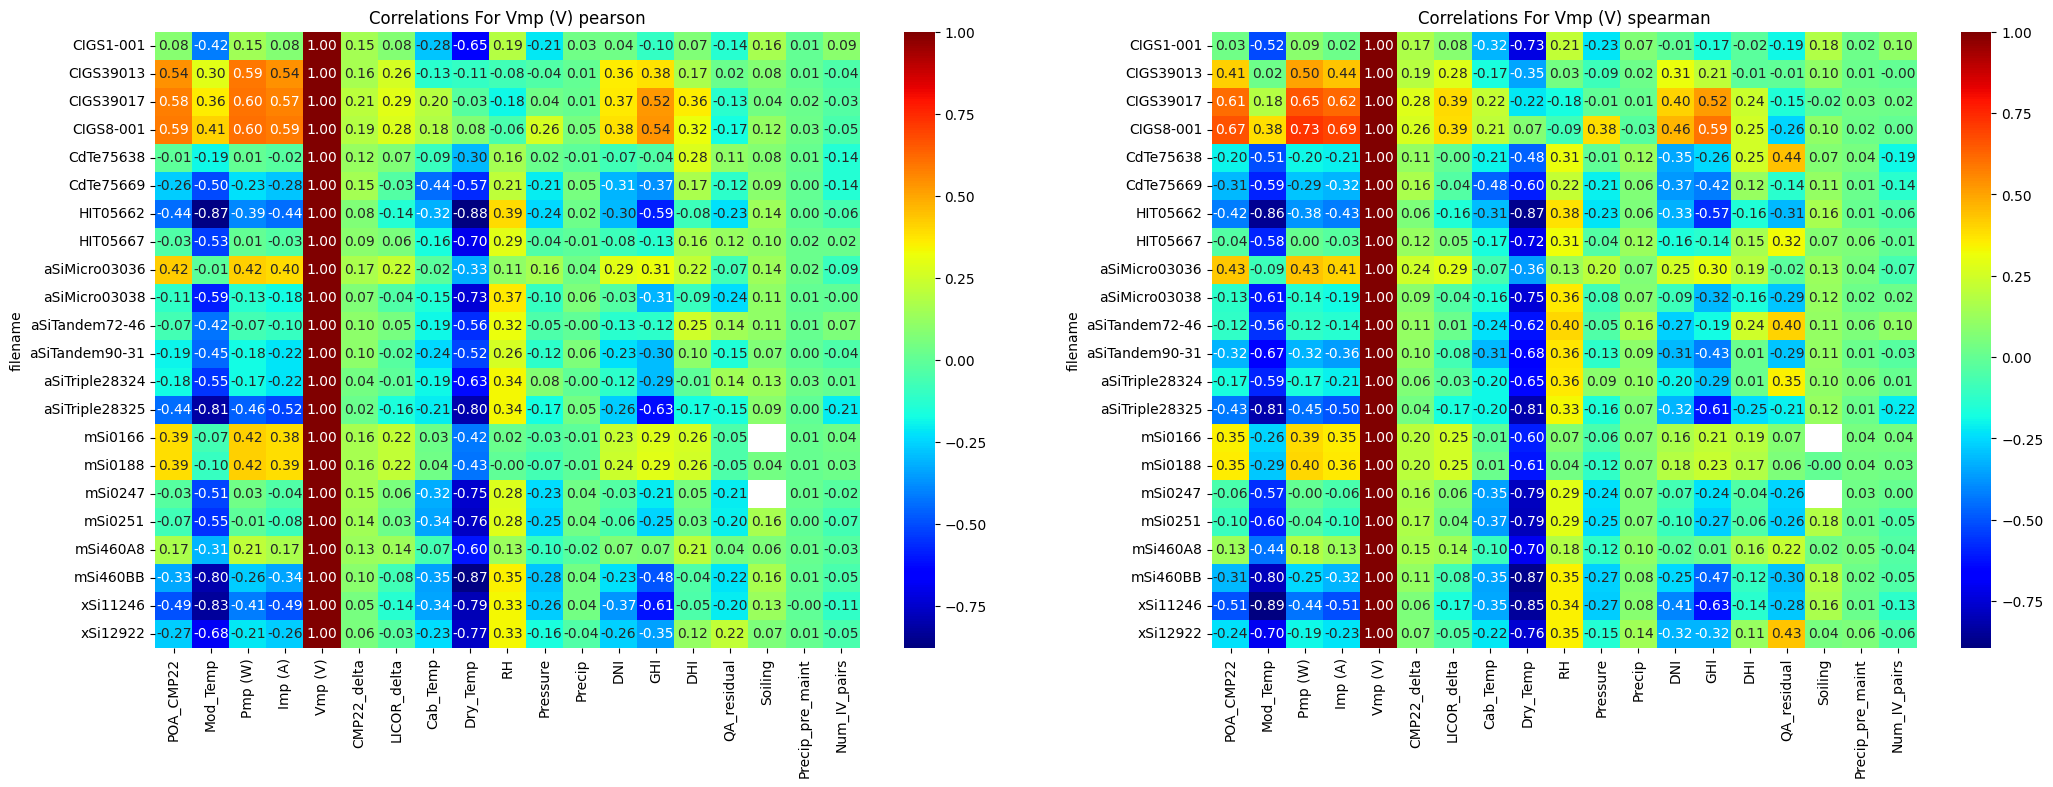

In [32]:
fig,ax=plt.subplots(1,2,figsize=(25,8))
d=main_df.drop(columns=lickage_features+["I-V paths"])
c=d.groupby("filename").corr(method="pearson")["Vmp (V)"]
corr_matrix = c.unstack(level=1)
sns.heatmap(corr_matrix,ax=ax[0],cmap="jet",annot=True,fmt=".2f")

c=d.groupby("filename").corr(method="spearman")["Vmp (V)"]
corr_matrix = c.unstack(level=1)
sns.heatmap(corr_matrix,ax=ax[1],cmap="jet",annot=True,fmt=".2f")

ax[0].set_title("Correlations For Vmp (V) pearson")
ax[1].set_title("Correlations For Vmp (V) spearman")

Text(0.5, 1.0, 'Correlations For Imp (A)')

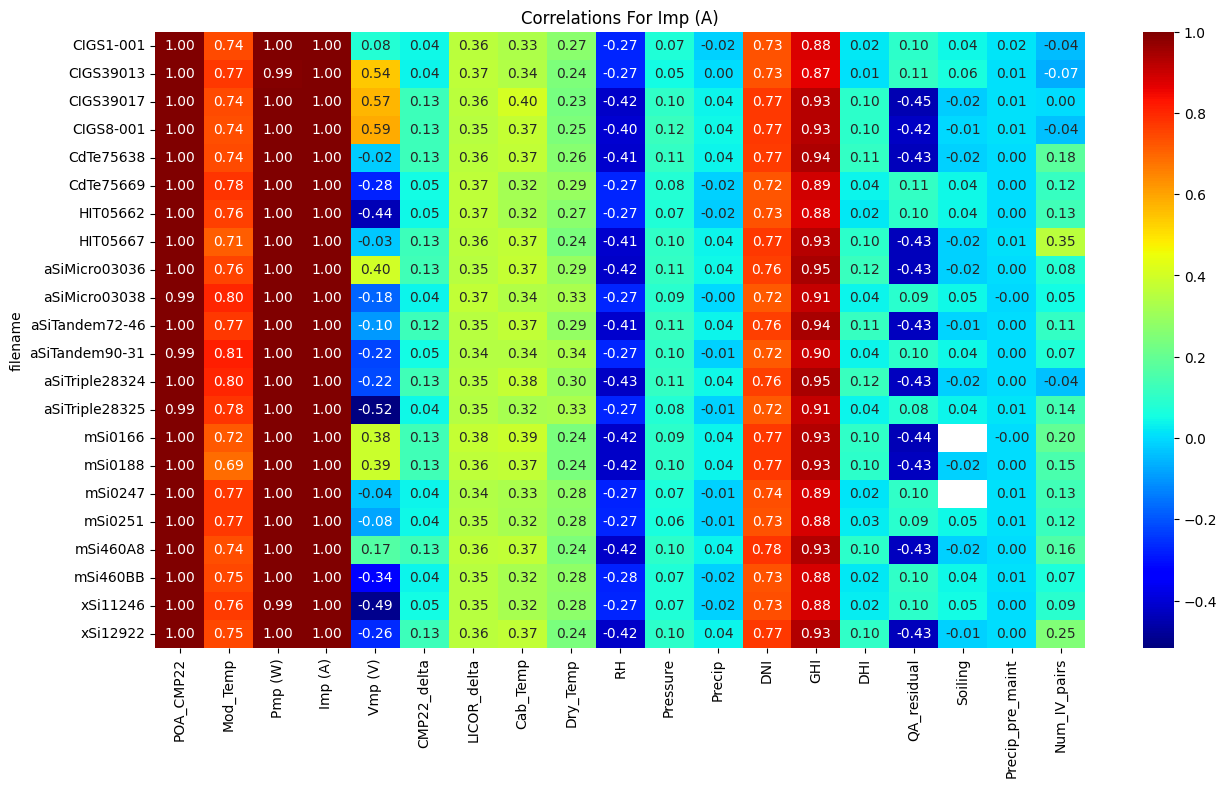

In [33]:
fig,ax=plt.subplots(1,1,figsize=(15,8))
d=main_df.drop(columns=lickage_features+["I-V paths"])
c=d.groupby("filename").corr()["Imp (A)"]
corr_matrix = c.unstack(level=1)
sns.heatmap(corr_matrix,ax=ax,cmap="jet",annot=True,fmt=".2f")
ax.set_title("Correlations For Imp (A)")

Text(0.5, 1.0, 'Correlations For Pmp (W)')

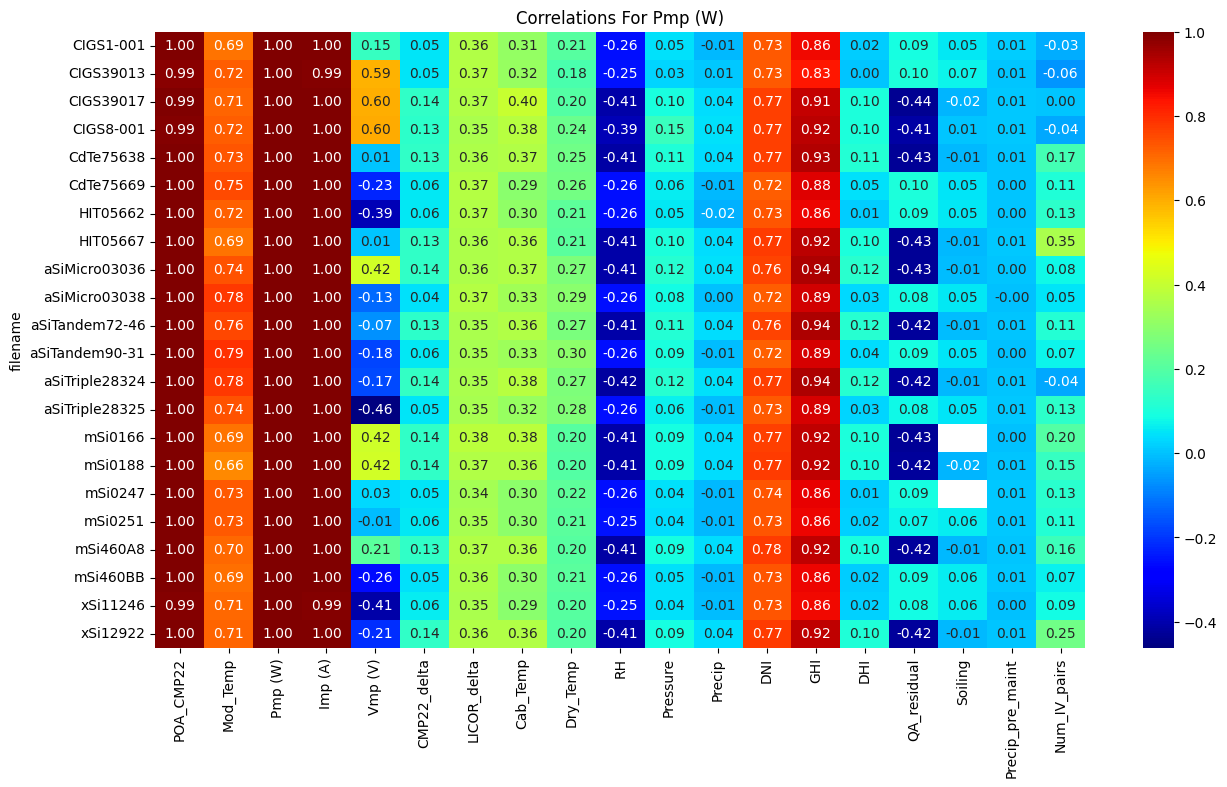

In [34]:
fig,ax=plt.subplots(1,1,figsize=(15,8))
d=main_df.drop(columns=lickage_features+["I-V paths"])
c=d.groupby("filename").corr()["Pmp (W)"]
corr_matrix = c.unstack(level=1)
sns.heatmap(corr_matrix,ax=ax,cmap="jet",annot=True,fmt=".2f")
ax.set_title("Correlations For Pmp (W)")

In [35]:
corr["Pmp (W)"].sort_values()

QA_residual        -0.406633
RH                 -0.341177
Precip             -0.077521
Soiling            -0.053955
Precip_pre_maint   -0.012756
Pressure            0.038444
Num_IV_pairs        0.132350
Vmp (V)             0.186342
Dry_Temp            0.193957
DHI                 0.207286
CMP22_delta         0.233855
Cab_Temp            0.314000
LICOR_delta         0.441884
Mod_Temp            0.641583
DNI                 0.661960
Imp (A)             0.800638
GHI                 0.810936
POA_CMP22           0.864995
Pmp (W)             1.000000
Name: Pmp (W), dtype: float64

In [36]:
columns

Index(['TimeStamp', 'POA_CMP22', 'POA_unc', 'Mod_Temp', 'Mod_Temp_unc',
       'Isc (A)', 'Isc_unc', 'Pmp (W)', 'Pmp_unc', 'Imp (A)', 'Imp_unc',
       'Vmp (V)', 'Vmp_unc', 'Voc (V)', 'Voc_unc', 'FF (%FF)', 'FF_unc',
       'CMP22_delta', 'LICOR_delta', 'Cab_Temp', 'Dry_Temp', 'Dry_Temp_unc',
       'RH', 'RH_unc', 'Pressure', 'Pressure_unc', 'Precip', 'DNI', 'DNI_unc',
       'DNI_std', 'GHI', 'GHI_unc', 'GHI_std', 'DHI', 'DHI_unc', 'DHI_std',
       'QA_residual', 'Soiling', 'Precip_pre_maint', 'Num_IV_pairs',
       'I-V paths', 'filename'],
      dtype='object')

In [37]:
sites=main_df["filename"].unique()

In [38]:
X=main_df.drop(columns=["Imp (A)","Pmp (W)","Vmp (V)"])
Y=main_df[["Imp (A)","Pmp (W)","Vmp (V)","filename"]]
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42,stratify=X["filename"])

In [39]:
features=["POA_CMP22","Dry_Temp"]
labels=["Imp (A)","Pmp (W)","Vmp (V)"]
n_row=len(labels)
n_col=len(features)
subplot_size=(8,8)
fig,axes=plt.subplots(n_row,n_col,figsize=(n_col*subplot_size[1],n_row*subplot_size[0]))
for i in range(n_row):
    for j in range(n_col):
        ax=axes[i*j] if (n_col==1 or n_row == 1) else axes[i,j]
        x_col=features[j]
        y_col=labels[i]
        sns.scatterplot(
            x=X[x_col],
            y=Y[y_col],
            hue=X["filename"],
            palette="tab20",
            ax=ax,
            legend="full",
            alpha=0.8
        )
# plt.show()
plt.savefig("full_scatter.png", bbox_inches='tight')

In [72]:
Y[["Imp (A)","Vmp (V)"]].mean()

Imp (A)     1.665659
Vmp (V)    39.823564
dtype: float64

# IV curve analysis

In [115]:
n_sample=6
samples=main_df.sample(random_state=42,n=n_sample)
sampled_paths=samples["I-V paths"].values
samped_imps=samples["Imp (A)"].values
samped_vmps=samples["Vmp (V)"].values
samped_pmps=samples["Pmp (W)"].values

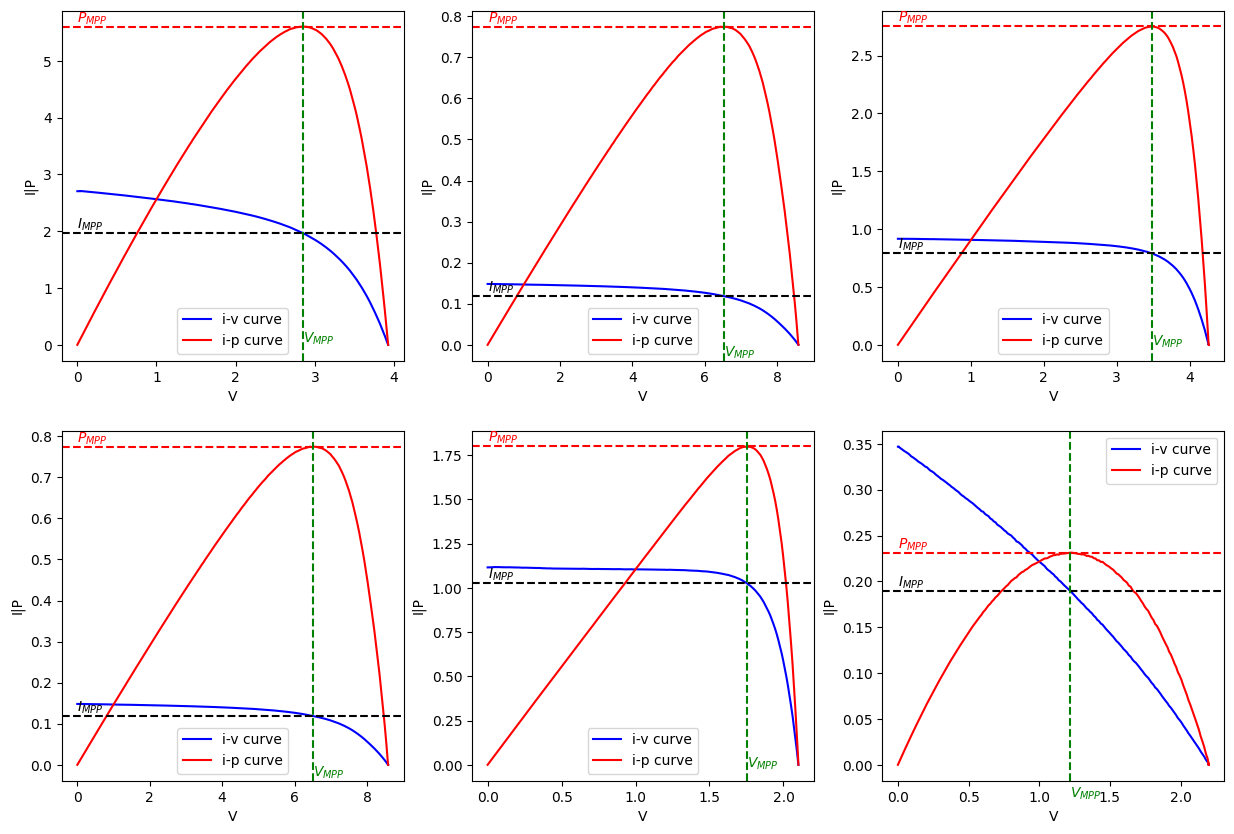

In [116]:
n_row=2
n_col=3
fig,axes=plt.subplots(n_row,n_col,figsize=(5*n_col,5*n_row))
scale=10
for i in range(n_row):
    for j in range(n_col):
        index=((i+1)*(j+1)) - 1
        iv_points=np.load(sampled_paths[index])
        imp=samped_imps[index]
        vmp=samped_vmps[index]/scale
        pmp=samped_pmps[index]/scale
        
        i_array=iv_points[:,0]
        v_array=iv_points[:,1]/scale
        p_array=(i_array*v_array)
        axes[i,j].plot(v_array,i_array,color="blue",label="V-I curve")
        axes[i,j].plot(v_array,p_array,color="red",label="V-P curve")
        axes[i,j].axhline(imp, color='k', ls='--')
        axes[i,j].axhline(pmp, color='r', ls='--')
        axes[i,j].axvline(vmp, color='g', ls='--')
        
        axes[i,j].set_xlabel("V")
        axes[i,j].set_ylabel("I|P")
        axes[i,j].text(0, imp, r'$I_{MPP}$',   va='bottom', ha='left')
        axes[i,j].text(0, pmp, r'$P_{MPP}$',   va='bottom', ha='left' , color='r')
        axes[i,j].text(vmp, -0.04, r'$V_{MPP}$', color='g',va='bottom', ha='left')
        axes[i,j].legend()